# Label Quality Scores for Regression with Noisy Labels 

This quickstart tutorial shows how to use cleanlab for finding label quality scores in regression datasets. Using the approach mentioned here, you can find label quality scores in any regression dataset irrespective of modality i.e. tabular, text, image, etc. 

**This example will take you through the following:**
- Generate label quality scores for each example in the dataset. 


Quickstart 

Cleanlab uses two inputs to generate scores for labels in the dataset:
- `labels`: NumPy array of given labels in the dataset. labels[i] should contain label for `i`-th example. 
- `predictions`: NumPy array of predictions generated through your favorite regressor. predictions[i] should contain predicted value for `i`-th example. 

If you already have predictions from your regressor, you can generate label quality scores for each example using the code below: 

<div  class=markdown markdown="1" style="background:white;margin:16px">

```python 

from cleanlab.regression.rank import get_label_quality_scores
label_quality_scores = get_label_quality_scores(labels, predictions)

```
</div>
</div>

## 1. Install dependencies and import them 
You can use `pip` to install all the packages required for this tutorial as follows:

`!pip install cleanlab xgboost`

In [1]:
# Package installation (hidden on docs website).
# Package versions we used: xgboost==1.7.2

dependencies = ["cleanlab", "xgboost"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = " ".join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [3]:
# This cell is hidden on docs.cleanlab.ai
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from cleanlab.regression.rank import get_label_quality_scores

np.set_printoptions(suppress=True)
SEED = np.random.RandomState(10203)

In this part, we have added a support function to plot the dataset for a quick demonstration. You can use it to highlight the examples based on label_quality_scores. You can skip this part and move to the next section. 

<details><summary>See the code for visualization **(click to expand)** </summary>

```python 
# Note: this pulldown is for docs.cleanlab.ai, if running on local Jupyter or colab, please ignore it. 

def plot_data(
    data_x, data_y, circles, title, alpha=0.6, color="#1f77b4", colorbar=False, xlabel="", ylabel=""
):
    plt.figure(figsize=(14, 5))
    data_x = data_x.to_numpy()
    data_y = data_y.to_numpy()
    plt.scatter(data_x, data_y, c=color, s=30)
    for i in circles:
        plt.plot(
            data_x[i],
            data_y[i],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=10,
            markeredgewidth=2.5,
            alpha=alpha,
        )
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if colorbar:
        plt.colorbar(orientation="vertical")

```
</details>

In [4]:
def plot_data(
    data_x, data_y, circles, title, alpha=0.6, color="#1f77b4", colorbar=False, xlabel="", ylabel=""
):
    plt.figure(figsize=(14, 5))
    data_x = data_x.to_numpy()
    data_y = data_y.to_numpy()
    plt.scatter(data_x, data_y, c=color, s=30)
    for i in circles:
        plt.plot(
            data_x[i],
            data_y[i],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=10,
            markeredgewidth=2.5,
            alpha=alpha,
        )
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if colorbar:
        plt.colorbar(orientation="vertical")

# 2. Import dataset and Generate predictions

In [5]:
# fetch the data
!wget -nc https://cleanlab-public.s3.amazonaws.com/Datasets/student_grades.csv

File 'student_grades.csv' already there; not retrieving.



In [6]:
# Load data
data = pd.read_csv("./student_grades.csv", index_col=0)
data.head()

,exam_1,exam_2,exam_3,notes,true_grade,grade
0,53,77,93,NaN,76.2,76.2
1,81,64,80,great participation +10,85.5,85.5
2,74,88,97,NaN,87.4,87.4
3,61,94,78,NaN,77.7,77.7
4,48,90,91,NaN,77.8,77.8


In the data frame displayed above, `grade` represents the noisy grades and `true_grade` represents the ground truth. Please note that ground truth is usually not available in a real dataset. We have added it here for comparison and to demonstrate our method. Also, note that column `notes` have categorical information. 

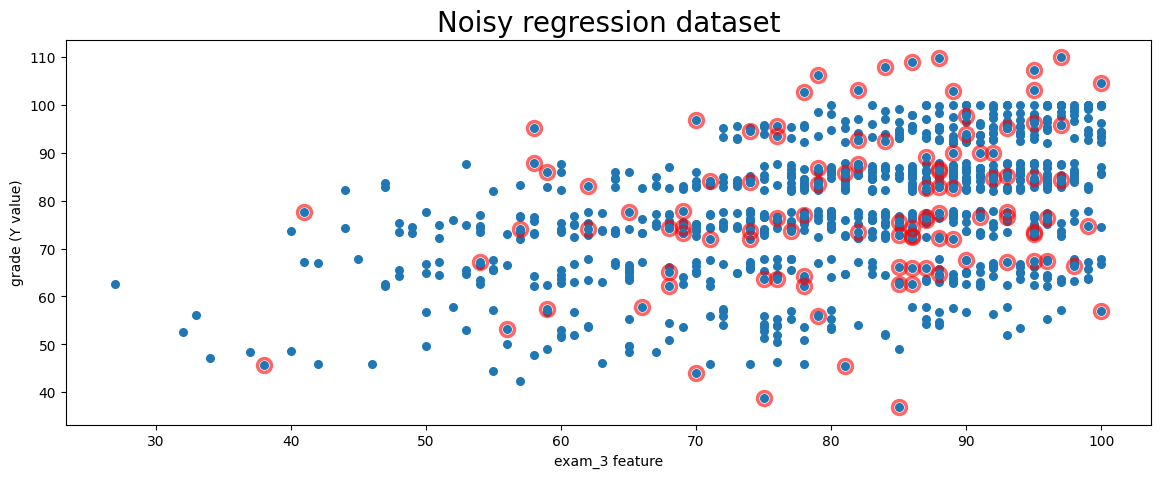

In [7]:
# Generate true errors
true_errors = (data["grade"] != data["true_grade"]).astype(int)
true_errors_index = np.where(true_errors == 1)[0]
plot_data(
    data_x=data["exam_3"],
    data_y=data["grade"],
    circles=true_errors_index,
    title="Noisy regression dataset",
    xlabel="exam_3 feature",
    ylabel="grade (Y value)",
)

In the above plot, `grade (Y value)` is plotted against one of the features in the dataset (`exam_3`). We have circled the examples that were considered as `true_error` in **Red**. 

Let's check some of the errors in next cell.  

In [8]:
# Some of the error in the dataset
display("Errors in dataset:", data.loc[true_errors_index].head())

# Dropping ground truth i.e. true_grade 
data = data.drop(columns=["true_grade"])

'Errors in dataset:'

,exam_1,exam_2,exam_3,notes,true_grade,grade
13,80,59,65,NaN,67.7,77.7
58,89,59,79,missed homework frequently -10,66.0,56.0
82,88,80,82,great participation +10,93.2,103.2
85,92,87,71,NaN,82.1,72.1
92,96,77,79,missed class frequently -10,73.5,83.5


We will use sklearn API `XGBRegressor` from `xgboost` as the regressor for this tutorial. `xgboost` provides easy to use interface to process categorical variables. In order to make inputs compatible with `xgboost`, we need to divide data in `X` and labels `y`. This is demonstrated in the code below: 

In [9]:
# xgboost automatically factors categorical variable, you just need to mark the columns as category
data.notes = data.notes.astype("category")

# xgboost takes data and label seperately, so you will need to divide data accordingly.
X = data.drop(columns=["grade"])
y = data["grade"]

Let's start with initializing the model with relevant parameters. As mentioned earlier we are using `xgboost` for this tutorial. To handle categorical variables, we specifically need to set `enable_categorical` flag to `True`. Note that, support for the categorical variable is in the experimental stage and doesn't support the auto-selection of `tree_method`. Therefore, you will need to specify `tree_method` from supported types. More details can be found [here](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html).

In [10]:
num_crossval_folds = 5

model = XGBRegressor(
    tree_method= "hist",
    n_estimators = 100,  
    enable_categorical = True, 
    random_state = SEED)

# get predictions using cross-validation
predictions = cross_val_predict(
    estimator=model, X=X, y=y, cv=num_crossval_folds, method = "predict"
)

An additional benefit of cross-validation is that it facilitates more reliable evaluation of our model than a single training/validation split.

In [11]:
roc = r2_score(y, predictions)
print(f"R-squared on predictions from cross-validation: {roc:.3f}")

R-squared on predictions from cross-validation: 0.902


## 3. Using cleanlab to generate label quality scores

Once you have the predictions from the cross-validation. You can generate label quality scores using cleanlab by running just one line of code. 

In [12]:
# get label quality score for each example in the dataset using cleanlab
label_quality_scores = get_label_quality_scores(labels=y, predictions=predictions)

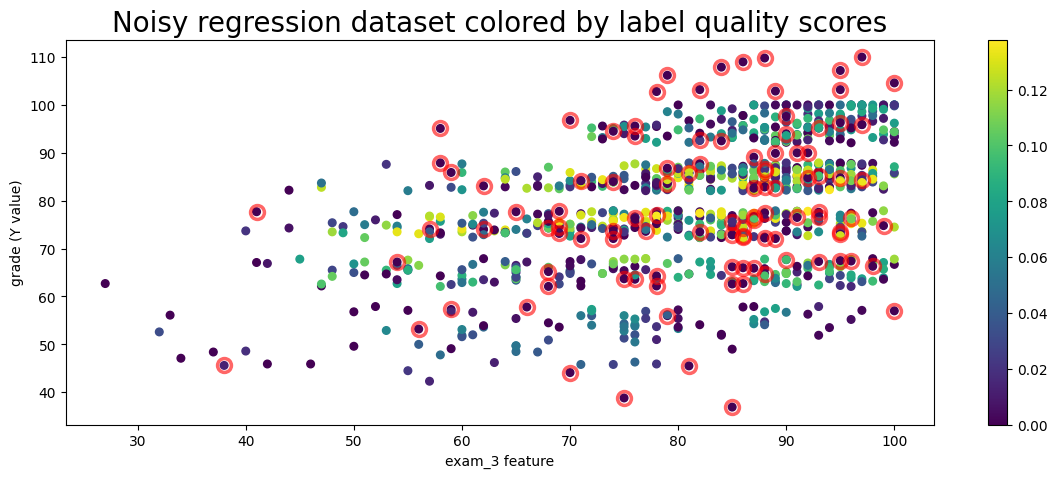

In [13]:
plot_data(
    data_x=data["exam_3"],
    data_y=data["grade"],
    circles=true_errors_index,
    color=label_quality_scores,
    title="Noisy regression dataset colored by label quality scores",
    colorbar=True,
    xlabel="exam_3 feature",
    ylabel="grade (Y value)",
)

In the above plot, we have colored each examples with their label quality scores generated using cleanlab. Examples are same as earlier plot displayed in the notebook.  `grade (Y value)` is plotted against one of the features in the dataset (`exam_3`)

**Red circle** represents the errors in `grade` with respect to the ground truth `true_grade`.  You can observe that our method assign low scores to examples that were considered as `true_error`

In [14]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
from sklearn.metrics import roc_auc_score

label_quality_scores = get_label_quality_scores(labels=y, predictions=predictions)
label_quality_scores_residual = get_label_quality_scores(labels = y, predictions=predictions, method="residual")

auc = roc_auc_score(true_errors, 1 - label_quality_scores)

if auc <= 0.5:
    raise ValueError("Label quality scores did not perform well enough")

if auc <= roc_auc_score(true_errors, 1 - label_quality_scores_residual):
    raise ValueError("Label quality scores did not outperform alternative scores")